Naive Bayes is an extremely simple classification scheme that often works amazingly well in practice.  We'll apply it to the [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), which we saw in Lecture 1.  First, let's import the dataset from sklearn and plot histograms of each class.

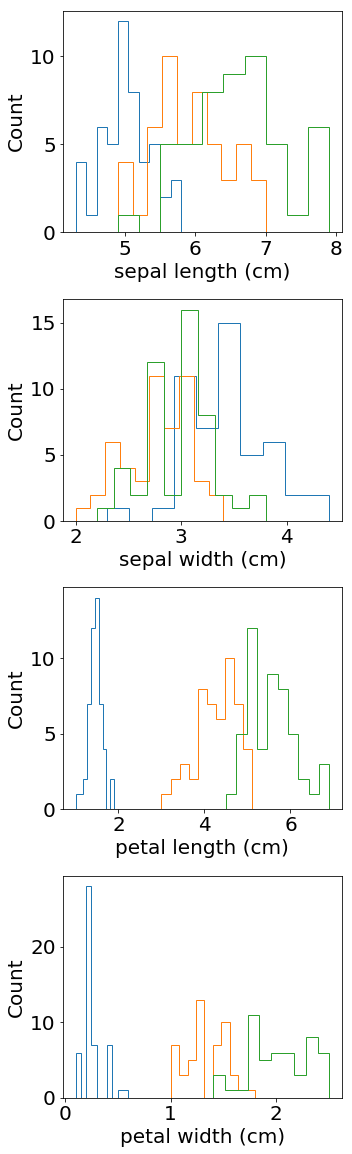

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [5,20]
mpl.rcParams['font.size'] = 20
import numpy as np

from sklearn import datasets

# Load the dataset
iris = datasets.load_iris()
X = iris.data    # n x m matrix of features 
Y = iris.target  # n vector of classes

classes = [0,1,2] #Numeric class identifiers: 0 -> Setosa, 1-> Versicolor, 2-> Virginica
N = len(classes) # The number of classes
m = X.shape[0]   # The number of data points
n = X.shape[1]   # The number of features

# Plot histograms of all the features
fig,axs = plt.subplots(nrows=4,ncols=1)
fig.subplots_adjust(hspace=0.3)
for i in range(4):
    axs[i].hist(X[Y==0,i],histtype='step')
    axs[i].hist(X[Y==1,i],histtype='step')
    axs[i].hist(X[Y==2,i],histtype='step')
    axs[i].set_xlabel(iris.feature_names[i])
    axs[i].set_ylabel('Count')

plt.show()

The method works in a two step processs: First, for a set of classes $C_k \in \{C_1,C_2,\ldots,C_N\}$, where $N$ is the number of possible class labels (2 in this case), use Bayes' rule to generate a probability that a data instance with a set of features $x_j$ belongs to each class, given a set of training data $D=(X,Y)$.  In step two, assign the class label with the highest probability to that data instance.  For each class $C_k$, we can use Bayes' rule to determine the probability:
$$ 
P(C_k|x_j,D) \propto P(x_j|C_k) P(C_k|D).
$$
However, this equation implies that we have to compute the joint probability of $x_j$, where there could be some complicated correlations between features.  We can simplify this model by assuming that all of the features ($x_i \in \mathbf{X}$) are independent, or
$$ P(\mathbf{x}|D,C_k) \approx \prod_{j=1}^n P(x_j|D,C_k), $$
where $n$ is the number of features in a data instance.  This is the so-called *naive Bayes* assumption, naive because it assumes no correlation between features.  This leads to the simpler model:
$$
P(C_k|\mathbf{x},D) \propto P(C_k|D) \prod_{j=1}^n P(x_j|D,C_k).
$$

Now, we need to specify the distributions for the class prior $P(C_k|D)$ and class likelihoods $P(x_i|D,C_k)$.  We can model the prior probability as a Bernoulli distribution 
$$P(C=C_k|D) = \eta_k, $$
where $\eta_k$ is the probability that we would label the feature $\mathbf{x}$ as class $C_k$, before having seen any of the values in $\mathbf{x}$.  There are different options here.  We could say that all classes are equally likely, so $\eta=1/N$.  A more common practice is to estimate $\eta$ as the maximum likelihood value from the training data $D$, which for a Bernoulli distribution is 
$$
\eta_k = \frac{\sum_{i=1}^n [C = C_k]}{\sum_{i=1}^n},
$$
or the total proportion of the training data where the label is $C_k$.  Note the use of the [Iverson Bracket](https://en.wikipedia.org/wiki/Iverson_bracket) in the above definition.



In [ ]:
etas = np.zeros((N_classes))
for C_k in [0,1]:
    etas[C_k] = len(Y[Y==C_k])/len(Y)
print(etas) #About fifty/fifty : a balanced dataset

For the likelihood, since we're considering continuous features, it makes sense to use a continous likelihood function.  While there are many options, a normal distribution should do the trick.  However, we need to use the training data to estimate the parameters of this normal distribution.  This is similar to what we did for the prior:
$$
P(x_j|C_k,D) = \int P(x_j|\mu_j,\sigma_j^2)\, P(\mu_j|C_k,D) \, P(\sigma_j^2|C_k,D) \;\mathrm{d}\mu_j\, \mathrm{d}\sigma_j^2.
$$
Assigning complete probability distributions to $\mu_j$ and $\sigma_j^2$ is the Bayesian thing to do, but leads to some complicated math and perhaps no analytical solution.  Instead, let's do what we did before and compute $\mu_j$ and $\sigma_j^2$ using maximum likelihood estimators, which for normally-distributed data are given by
$$
\mu_{jk,MLE} = \frac{\sum_{i=1}^n x_{ji} [C_i=C_k]}{\sum_{i=1}^n [C_i=C_k]},
$$
and 
$$
\sigma_{jk,MLE}^2 = \frac{ (\sum_{i=1}^n (x_{ji} - \mu_j)^2 [C_i=C_k])}{(\sum_{i=1}^n [C_i=C_k]) - 1},
$$
which are just the sample mean and sample variance of the training data examples for which the class is $C_k$.

In [ ]:
mus = np.zeros((N_classes))
variances = np.zeros((N_classes))
for C_k in [0,1]:
    mus[C_k] = np.mean(X[Y==C_k])
    variances[C_k] = np.std(X[Y==C_k])**2
print(mus,variances)

Now, we can just evaluate the probability of each example, with respect to each class, and classify as the one with the highest probability.

In [ ]:
class_posterior = np.zeros((m,N_classes))

for i in range(m):
    for C_k in range(N_classes):
        likelihood = 1./np.sqrt(2*np.pi*variances[C_k])*np.exp(-(X[i] - mus[C_k])**2/(2*variances[C_k]))
        prior = etas[C_k]
        class_posterior[i,C_k] = likelihood*prior
    class_posterior[i,:]/=np.sum(class_posterior[i])

print(class_posterior)

This is easier to understand if we plot it:

In [ ]:
plt.hist(X[Y==0],label='Dead Lobster',bins=np.arange(25,60,3),histtype='step')
plt.hist(X[Y==1],label='Alive Lobster',bins=np.arange(25,60,3),histtype='step')
plt.xlabel('Lobster Size')
plt.ylabel('Count')
plt.legend()

ax2 = plt.twinx()
ax2.plot(X,class_posterior[:,0])
ax2.plot(X,class_posterior[:,1])
ax2.set_ylabel('Class Posterior Probability')
plt.show()


Let's try something similar with the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set), which was first introduced by Ronald A. Fisher in 1936.  It provides four features: petal length, petal width, sepal length, and sepal width, along with a class label that divides the data into three classes: *Iris setosa, Iris virginica and Iris versicolor*.  It has since become a classic for testing machine learning algorithms, and is available in scikit-learn.  Let's import it and have a look:

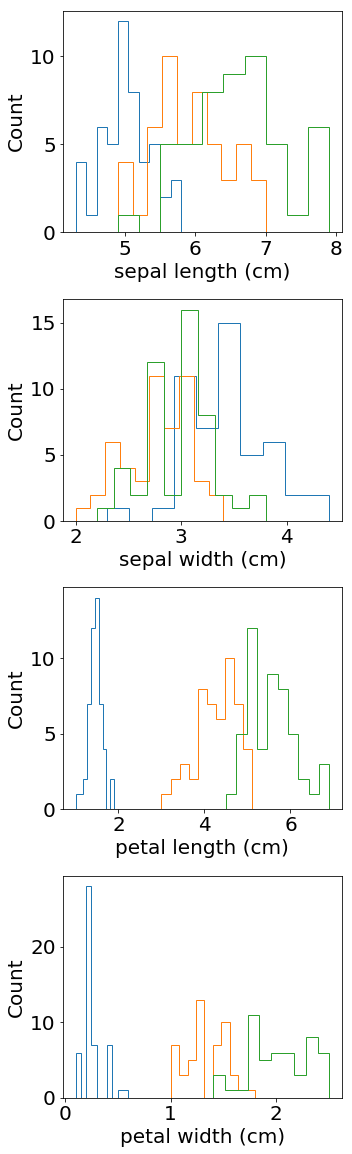

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [5,20]
mpl.rcParams['font.size'] = 20
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load the dataset
iris = datasets.load_iris()
X = iris.data    # n x m matrix of features 
Y = iris.target  # n vector of classes

classes = [0,1,2] #Numeric class identifiers: 0 -> Setosa, 1-> Versicolor, 2-> Virginica
N = len(classes)
m = X.shape[0]
n = X.shape[1]

fig,axs = plt.subplots(nrows=4,ncols=1)
fig.subplots_adjust(hspace=0.3)
for i in range(4):
    axs[i].hist(X[Y==0,i],histtype='step')
    axs[i].hist(X[Y==1,i],histtype='step')
    axs[i].hist(X[Y==2,i],histtype='step')
    axs[i].set_xlabel(iris.feature_names[i])
    axs[i].set_ylabel('Count')


plt.show()


First, we can use the multinomial maximum likelihood estimators to find the class priors $P(Y=C_k) = \theta_k = \frac{1}{m} \sum_{i=1}^m [Y_i = C_k]$.

In [ ]:
theta_prior = np.zeros((N))
theta_prior[0] = sum(Y==0)/m
theta_prior[1] = sum(Y==1)/m
theta_prior[2] = sum(Y==2)/m
print(theta_prior)


The likelihood model in this case is a little bit more tricky though.  First, the values are real, which means that we'll need to fit a normal distribution.  However, there are four attributes (Petal width/length, Sepal width/length).  That means that the natural distribution to fit is a multivariate normal:
$$
P(X|Y=C_k) \propto \exp -\frac{1}{2} (X-\mu_k)^T \Sigma_k (X-\mu_k),
$$
where $\mu_k \in \mathbb{R}^4$ is the mean and $\Sigma_k \in \mathbb{R}^{4\times4}$ is the covariance matrix.  It's useful to look at data under different assumptions about the covariance matrix to get a sense for what it means.  However, it's impossible to properly visualize data in $\mathbb{R}^4$.  Instead, let's look at some made up data in $\mathbb{R}^2$.   





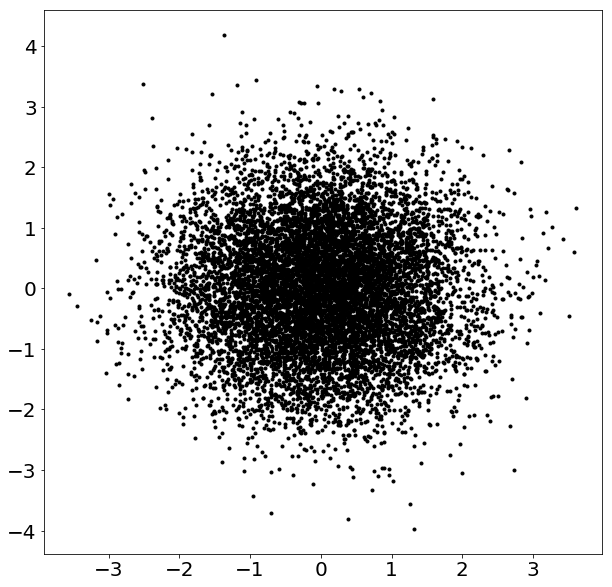

In [6]:
mpl.rcParams['figure.figsize'] = [10,10]

Sigma = np.array([[1,0.0],[0.0,1]])
A = np.linalg.cholesky(Sigma)
mu = np.array([0,0])
y = np.random.randn(2,10000)
x = np.dot(A,y).T + mu

plt.plot(x[:,0],x[:,1],'k.')




Notice that as the diagonals of the covariance matrix get bigger, the closer the variables are to having the same information!  While we can't look at the iris data in the same way, we can plot the variables pairwise as an approximation.

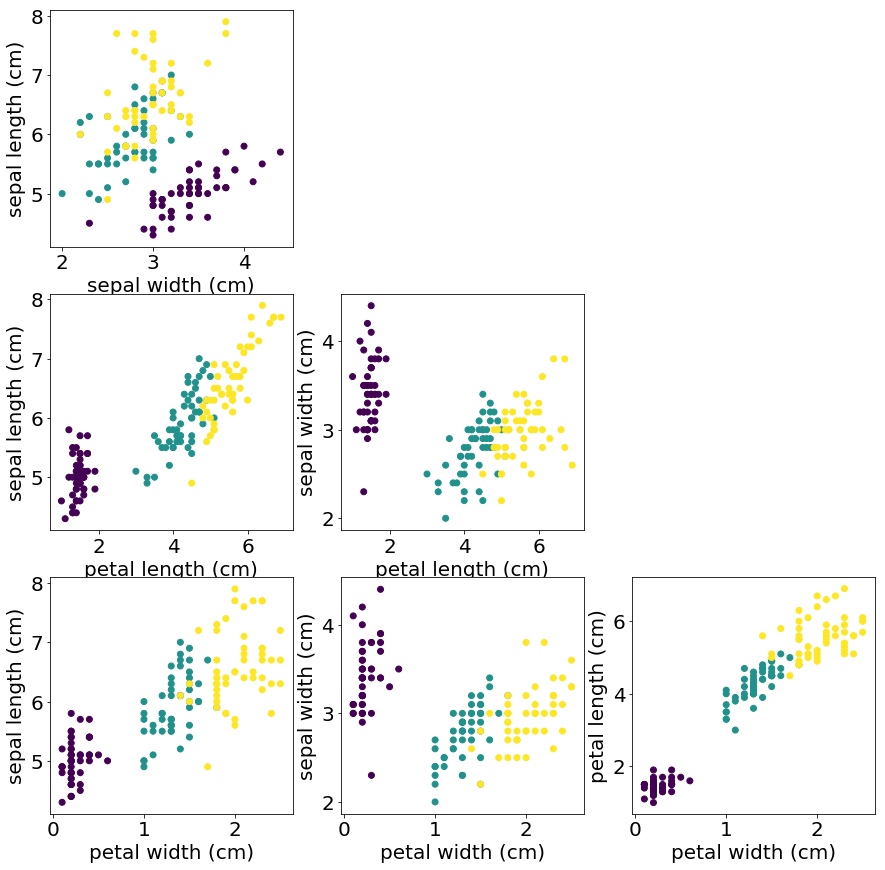

In [7]:
mpl.rcParams['figure.figsize'] = [20,20]

# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=Y)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
        else: # delete redundant plots
            fig.delaxes(axs[i,j])

There's certainly some correlation here, but not a ton.  Can we reasonably quantify it though?  For each class, we have about 50 samples, but we need to fit a model with 20 parameters, for a little over two data points per parameter.  That makes it unlikely that we'll be able to get a good estimate for covariance.  For larger problems with 1000s of parameters, it becomes even more difficult.  Thus we can make the naive assumption:
$$P(X|Y=C_k) = P(X_1|Y=C_k) P(X_2|Y=C_k) P(X_3|Y=C_k) P(X_4|Y=C_k)$$
then, it's quite easy to fit each feature independently with a univariate normal distribution.


In [ ]:
m

For each class, we will need the $n$ values of $\mu_i$ and $\sigma_i^2$, let's define $n \times N$ arrays to hold these values, as well as the $N$ prior probabilities that we will need

In [ ]:
mu = np.zeros((n,N))
sigma2 = np.zeros((n,N))

Then we can compute these values by looping over the $N$ classes 

In [ ]:
#Learning phase
for k in range(N):    #Loop over each class label
    C_k = classes[k]
    for j in range(n):   #Loop over the features
        mu[j,k] = np.mean(X[Y==C_k,j])          # Take the mean of those features where the corresponding label is C_k
        sigma2[j,k] = np.std(X[Y==C_k,j])**2  # Take the variance of those features where the corresponding label is C_k
   
print(mu)
print(sigma2)

And that's it for the training phase.  We can easily visualize the univariate normals that we've fit to each feature.

In [ ]:
mpl.rcParams['figure.figsize'] = [10,10]
plt.hist(X[Y==0.,3],label='Setosa',histtype='step',density=True)
plt.hist(X[Y==1.,3],label='Versicolor',histtype='step',density=True)
plt.hist(X[Y==2.,3],label='Virginica',histtype='step',density=True)
plt.xlabel('Petal Width')
plt.ylabel('Probability Density')
plt.legend()

x = np.linspace(0,2.5,201)
plt.plot(x,1./np.sqrt(2*np.pi*sigma2[3,0])*np.exp(-(x-mu[3,0])**2/sigma2[3,0]))
plt.plot(x,1./np.sqrt(2*np.pi*sigma2[3,1])*np.exp(-(x-mu[3,1])**2/sigma2[3,1]))
plt.plot(x,1./np.sqrt(2*np.pi*sigma2[3,2])*np.exp(-(x-mu[3,2])**2/sigma2[3,2]))

In order to get the probability of class membership for a new observation, all we need to do is to evaluate the likelihood for each class, multiply it by the class prior, then (optionally) normalize to get a probability

In [ ]:
# Prediction:
X_example = np.array([7.65, 3.3 , 6.25, 1.95])
#X_example= np.array([6.2 , 2.85, 4.75, 1.65])
class_probabilities = np.zeros((N))  # The probability of membership for each class

for k in range(N):    # Loop over the classes
    class_probabilities[k] = theta_prior[k]
    for j in range(n):
        feature_likelihood = 1./np.sqrt(2*np.pi*sigma2[j,k])*np.exp(-(X_example[j]-mu[j,k])**2/(2*sigma2[j,k]))
        class_probabilities[k]*=feature_likelihood
        
        
class_probabilities /= np.sum(class_probabilities)
print (class_probabilities)


In [ ]:
mpl.rcParams['figure.figsize'] = [20,20]

# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=Y)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
            axs[i,j].scatter(X_example[i],X_example[j],c='red')
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.plot()

This is unambiguous, as it should be.  What if we do the same thing for an edge case?